# PathML Graph construction and processing 

In this notebook, we will demonstrate the ability of the new pathml.graph API to construct cell and tissue graphs. Specifically, we will do the following:

1. Use a pre-trained HoVer-Net model to detect cells in a given Region of Interested (ROI)
2. Use boundary detection techniques to detect tissues in a given ROI
3. Featurize the detected cell and tissue patches using a ResNet model
4. Construct both tissue and cell graphs using k-Nearest Neighbour (k-NN) and Region-Adjacency Graph (RAG) methods and save them as torch tensors.

To get the full functionality of this notebook for a real-world dataset, we suggest you download the BRACS ROI set from the [BRACS dataset](https://www.bracs.icar.cnr.it/download/). To do so, you will have to sign up and create an account. Next, you will just have to replace the root folder in this tutorial to whatever directory you download the BRACS dataset to. 

In this notebook, we will use a representative image from this [link](https://github.com/histocartography/hact-net/tree/main/data) stored in `data/`.

In [1]:
import os
from glob import glob
import argparse
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch 
import h5py
import warnings
import math
from skimage.measure import regionprops, label
import networkx as nx
import traceback
from glob import glob

from pathml.core import HESlide, SlideData
import matplotlib.pyplot as plt 
from pathml.preprocessing.transforms import Transform
from pathml.core import HESlide
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE, NucleusDetectionHE
import pathml.core.tile
from pathml.ml import HoVerNet, loss_hovernet, post_process_batch_hovernet

from pathml.datasets.utils import DeepPatchFeatureExtractor
from pathml.preprocessing import StainNormalizationHE
from pathml.graph import RAGGraphBuilder, KNNGraphBuilder
from pathml.graph import ColorMergedSuperpixelExtractor
from pathml.graph.utils import _valid_image, _exists, plot_graph_on_image, get_full_instance_map, build_assignment_matrix

## Building a HoverNetNucleusDetectionHE class using pathml.transforms API 

First, we will use a pre-trained HoVer-Net model to detect cells and return a instance map containing masks that corresponds to cells. We will use the `pathml.preprocessing.transforms` class that can be used to apply a function over each ROI. The new `HoverNetNucleusDetectionHE` simply inherits this class and applies a HoVer-Net model onto each ROI that is passed into it. 

To obtain the pre-trained HoVer-Net model, we follow the steps in this [tutorial](https://pathml.readthedocs.io/en/latest/examples/link_train_hovernet.html). For simplicity, we provide a pre-trained model under the `pretrained_models` folder. 

In [2]:
class HoverNetNucleusDetectionHE(Transform):
    
    """
    Nucleus detection algorithm for H&E stained images using pre-trained HoverNet Model.

    Args:
        mask_name (str): Name of mask that is created.
        model_path (str): Path to the pretrained model. 
    
    References:
        Graham, S., Vu, Q.D., Raza, S.E.A., Azam, A., Tsang, Y.W., Kwak, J.T. and Rajpoot, N., 2019. 
        Hover-net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images. 
        Medical image analysis, 58, p.101563.
        
    """
    
    def __init__(
        self,
        mask_name,
        model_path = None
    ):
        self.mask_name = mask_name
        
        cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if cuda else "cpu")
        
        if model_path is None:
            raise NotImplementedError("Downloadable models not available")
        else:
            checkpoint = torch.load(model_path)
            self.model = HoVerNet(n_classes=6)
            self.model.load_state_dict(checkpoint)
        
        self.model = self.model.to(self.device)
        self.model.eval()

    def F(self, image):
        assert (
            image.dtype == np.uint8
        ), f"Input image dtype {image.dtype} must be np.uint8"
        
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)
        image = image.unsqueeze(0)
        image = image.to(self.device)
        with torch.no_grad():
            out = self.model(image)
            preds_detection, _ = post_process_batch_hovernet(out, n_classes=6)
        preds_detection = preds_detection.transpose(1,2,0)
        return preds_detection

    def apply(self, tile):
        assert isinstance(
            tile, pathml.core.tile.Tile
        ), f"tile is type {type(tile)} but must be pathml.core.tile.Tile"
        assert (
            self.mask_name is not None
        ), "mask_name is None. Must supply a valid mask name"
        assert (
            tile.slide_type.stain == "HE"
        ), f"Tile has slide_type.stain={tile.slide_type.stain}, but must be 'HE'"
        
        nucleus_mask = self.F(tile.image)
        tile.masks[self.mask_name] = nucleus_mask

A simple example on using this class is given below. The input image for this is present in the `data` folder. 

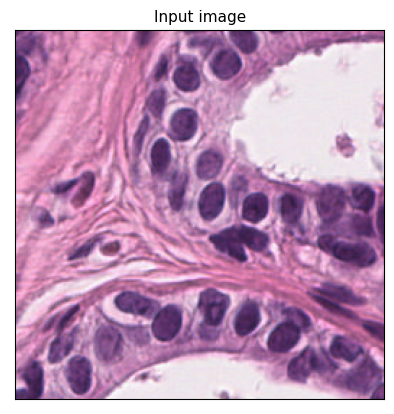

In [3]:
wsi = SlideData('../data/example_0_N_0.png', name = 'example', backend = "openslide", stain = 'HE')
region = wsi.slide.extract_region(location = (900, 800), size = (256, 256))
plt.imshow(region)
plt.title('Input image', fontsize=11)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

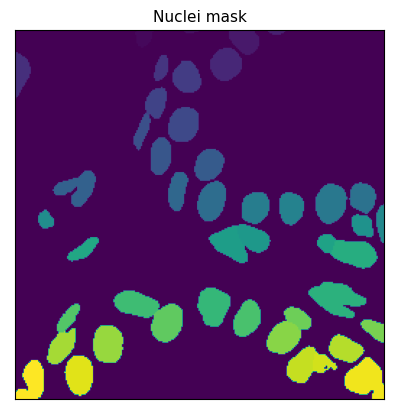

In [4]:
nuclei_detect = HoverNetNucleusDetectionHE(mask_name = 'cell', model_path = '../pretrained_models/hovernet_fully_trained.pt')
cell_mask = nuclei_detect.F(region)
plt.imshow(cell_mask)
plt.title('Nuclei mask', fontsize=11)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

## Cell and Tissue graph construction

Next, we can move on to applying a function that uses the new `pathml.graph` API to construct cell and tissue graphs.

We have to first define some constants. 

In [5]:
# Convert the tumor time given in the filename to a label
TUMOR_TYPE_TO_LABEL = {
    'N': 0,
    'PB': 1,
    'UDH': 2,
    'ADH': 3,
    'FEA': 4,
    'DCIS': 5,
    'IC': 6
}

# Define minimum and maximum pixels for processing a ROI
MIN_NR_PIXELS = 50000
MAX_NR_PIXELS = 50000000  

# Define the reference image and HoVer-Net model path
ref_path = '../data/example_0_N_0.png'
hovernet_model_path = '../pretrained_models/hovernet_fully_trained.pt'

# Define the patch size for applying HoverNetNucleusDetectionHE 
PATCH_SIZE = 256

Next, we write the main preprocessing loop as a function. 

In [9]:
def process(image_path, save_path, split, plot=True, overwrite=False):
    # 1. get image path
    subdirs = os.listdir(image_path)
    image_fnames = []
    for subdir in (subdirs + ['']):  
        image_fnames += glob(os.path.join(image_path, subdir, '*.png'))
        
    image_ids_failing = []
    
    print('*** Start analysing {} image(s) ***'.format(len(image_fnames)))
    
    ref_image = np.array(Image.open(ref_path))
    norm = StainNormalizationHE(stain_estimation_method='vahadane')
    norm.fit_to_reference(ref_image)
    ref_stain_matrix = norm.stain_matrix_target_od 
    ref_max_C = norm.max_c_target 
    
    for image_path in tqdm(image_fnames):
        
        # a. load image & check if already there 
        _, image_name = os.path.split(image_path)
        image = np.array(Image.open(image_path))

        # Compute number of pixels in image and check the label of the image
        nr_pixels = image.shape[0] * image.shape[1]
        image_label = TUMOR_TYPE_TO_LABEL[image_name.split('_')[2]]

        # Get the output file paths of cell graphs, tissue graphs and assignment matrices
        cg_out = os.path.join(save_path, 'cell_graphs', split, image_name.replace('.png', '.pt'))
        tg_out = os.path.join(save_path, 'tissue_graphs', split, image_name.replace('.png', '.pt'))
        assign_out = os.path.join(save_path, 'assignment_matrices', split, image_name.replace('.png', '.pt')) 

        # If file was not already created or not too big or not too small, then process 
        if not _exists(cg_out, tg_out, assign_out, overwrite) and _valid_image(nr_pixels):
            
            print(f'Image size: {image.shape[0], image.shape[1]}')

            if plot:
                print('Input ROI:')
                plt.imshow(image)
                plt.show()
            
            try:
                # Read the image as a pathml.core.SlideData class
                print('\nReading image')
                wsi = SlideData(image_path, name = image_path, backend = "openslide", stain = 'HE')

                # Apply our HoverNetNucleusDetectionHE as a pathml.preprocessing.Pipeline over all patches
                print('Detecting nuclei')
                pipeline = Pipeline([HoverNetNucleusDetectionHE(mask_name='cell', 
                                                                model_path=hovernet_model_path)])
                
                # Run the Pipeline 
                wsi.run(pipeline, overwrite_existing_tiles=True, distributed=False, tile_pad=True, tile_size=PATCH_SIZE)

                # Extract the ROI, nuclei instance maps as an np.array from a pathml.core.SlideData object
                image, nuclei_map, nuclei_centroid = get_full_instance_map(wsi, patch_size = PATCH_SIZE)

                # Use a ResNet-34 to extract the features from each detected cell in the ROI
                print('Extracting features from cells')
                extractor = DeepPatchFeatureExtractor(patch_size=64, 
                                            batch_size=64, 
                                            entity = 'cell',
                                            architecture='resnet34', 
                                            fill_value=255, 
                                            resize_size=224,
                                            threshold=0)
                features = extractor.process(image, nuclei_map)

                # Build a kNN graph with nodes as cells, node features as ResNet-34 computed features, and edges within
                # a threshold of 50
                print('Building graphs')
                knn_graph_builder = KNNGraphBuilder(k=5, thresh=50, add_loc_feats=True)
                cell_graph = knn_graph_builder.process(nuclei_map, features, target = image_label)

                # Plot cell graph on ROI image 
                if plot:
                    print('Cell graph on ROI:')
                    plot_graph_on_image(cell_graph, image)

                # Save the cell graph 
                torch.save(cell_graph, cg_out)

                # Detect tissue using pathml.graph.ColorMergedSuperpixelExtractor class
                print('\nDetecting tissue')
                tissue_detector = ColorMergedSuperpixelExtractor(superpixel_size=200,
                                                                 compactness=20,
                                                                 blur_kernel_size=1,
                                                                 threshold=0.05,
                                                                 downsampling_factor=4)

                superpixels, _ = tissue_detector.process(image)

                # Use a ResNet-34 to extract the features from each detected tissue in the ROI
                print('Extracting features from tissues')
                tissue_feature_extractor = DeepPatchFeatureExtractor(architecture='resnet34',
                                                                       patch_size=144,
                                                                       entity = 'tissue',
                                                                       resize_size=224,
                                                                       fill_value=255,
                                                                       batch_size=32,
                                                                       threshold = 0.25)
                features = tissue_feature_extractor.process(image, superpixels)

                # Build a RAG with tissues as nodes, node features as ResNet-34 computed features, and edges using the 
                # RAG algorithm
                print('Building graphs')
                rag_graph_builder = RAGGraphBuilder(add_loc_feats=True)
                tissue_graph = rag_graph_builder.process(superpixels, features, target = image_label)

                # Plot tissue graph on ROI image
                if plot:
                    print('Tissue graph on ROI:')
                    plot_graph_on_image(tissue_graph, image)

                # Save the tissue graph 
                torch.save(tissue_graph, tg_out)  

                # Build as assignment matrix that maps each cell to the tissue it is a part of 
                assignment = build_assignment_matrix(nuclei_centroid, superpixels)

                # Save the assignment matrix
                torch.save(torch.tensor(assignment), assign_out)
          
            except:
                print(f'Failed {image_path}')
                image_ids_failing.append(image_path)
            
    print('\nOut of {} images, {} successful graph generations.'.format(
            len(image_fnames),
            len(image_fnames) - len(image_ids_failing)
        ))
    print('Failing IDs are:', image_ids_failing)


Finally, we write a main function that calls the process function for a specified root and output directory, along with the name of the split (either train, test or validation if using BRACS). 

In [10]:
def main(base_path, save_path, split=None):
    if split is not None:
        root_path = os.path.join(base_path, split)
    else:
        root_path = base_path
    
    print(root_path)
    
    os.makedirs(os.path.join(save_path, 'cell_graphs', split), exist_ok=True)
    os.makedirs(os.path.join(save_path, 'tissue_graphs', split), exist_ok=True)
    os.makedirs(os.path.join(save_path, 'assignment_matrices', split), exist_ok=True)
    
    process(root_path, save_path, split, plot=True, overwrite=True)

../data/
*** Start analysing 1 image(s) ***


  0%|                                                                                                  | 0/1 [00:00<?, ?it/s]

Image size: (1949, 2377)
Input ROI:


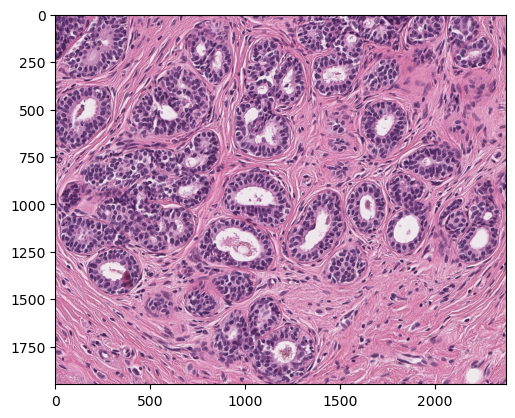

Reading image
Detecting nuclei
Extracting features from cells


  0%|          | 0/49 [00:00<?, ?it/s]

Building graphs
Cell graph on ROI:


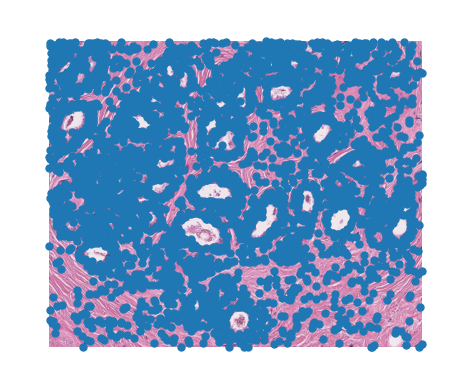


Detecting tissue
Extracting features from tissues


  0%|          | 0/10 [00:00<?, ?it/s]

Building graphs
Tissue graph on ROI:


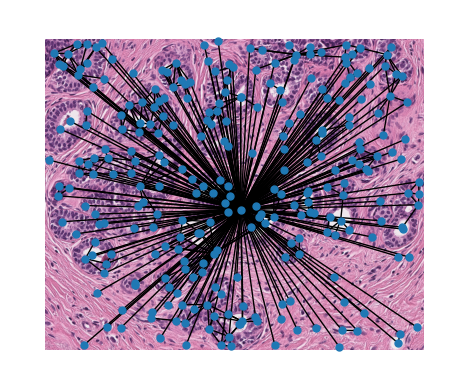

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.78s/it]


Out of 1 images, 1 successful graph generations.
Failing IDs are: []


In [11]:
# Folder containing all images
base = '../data/'

# Output path 
save_path = '../data/output/'

# Start preprocessing
main(base, save_path, split='')

## References

*  Pati, Pushpak, Guillaume Jaume, Antonio Foncubierta-Rodriguez, Florinda Feroce, Anna Maria Anniciello, Giosue Scognamiglio, Nadia Brancati et al. "Hierarchical graph representations in digital pathology." Medical image analysis 75 (2022): 102264.
*  Brancati, Nadia, Anna Maria Anniciello, Pushpak Pati, Daniel Riccio, Giosuè Scognamiglio, Guillaume Jaume, Giuseppe De Pietro et al. "Bracs: A dataset for breast carcinoma subtyping in h&e histology images." Database 2022 (2022): baac093.

## Session info

In [13]:
import IPython
print(IPython.sys_info())
print(f"torch version: {torch.__version__}")

{'commit_hash': 'f4b5b55',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/opt/conda/envs/pathml_graph_dev/lib/python3.9/site-packages/IPython',
 'ipython_version': '8.16.0',
 'os_name': 'posix',
 'platform': 'Linux-4.19.0-25-cloud-amd64-x86_64-with-glibc2.28',
 'sys_executable': '/opt/conda/envs/pathml_graph_dev/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.9.18 | packaged by conda-forge | (main, Aug 30 2023, '
                '03:49:32) \n'
                '[GCC 12.3.0]'}
torch version: 1.13.1
